In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math

# need to install line_profiler
# username$ conda install line_profiler
%load_ext line_profiler

In [2]:
# This function replicates bacteria when bacthist catches up with bacthist
def repBacteria(bactpos,bactrep,bacthist,nlive):
    repind = bactrep < bacthist[0:nlive]           #indices of bacteria that will replicate
    repind = repind.reshape(nlive)                 #reshape repind for indexing
    nrep = np.sum(repind)                          #number of bacteria that replicate
    newbact = bactpos[repind,:]                    #positions of newly-replicated bacteria
    bacthist[0:nlive][repind] = 0                  #bacterial history is reset to zero
    return bacthist,newbact,nrep

# This function runs the simulation in a for loop
def runSimulation(step,nlive,D,delt,dTime,sigma,bactpos,bacthist,bactrep,bacteria_number):
    
    while(1):
    
        # Step 1: calculate time
        bacthist[0:nlive] = bacthist[0:nlive] + delt
    
        # Step 2: calculate size of bacterial steps
        delxy = np.random.normal(0,1,[nlive,2])*math.sqrt(2*D*delt)
        bactpos[0:nlive] = bactpos[0:nlive] + delxy
    
        # Step 3: replicate bacteria
        bacthist,newbact,nrep = repBacteria(bactpos[0:nlive],bactrep[0:nlive],bacthist,nlive)
        if nrep>0:
            bactpos[nlive:nlive+nrep] = newbact
            bactrep[nlive:nlive+nrep] = np.random.normal(dTime, sigma, [nrep,1])
            nlive += nrep
        bacteria_number[step] = nlive
        step+=1
        
        # Step 4: end simulation if you have accumulated enough bacteria
        if nlive>maxnbact:
            return bactpos,bacteria_number,nlive,step

# This function sets up more parameters and calls runSimulation
def startSimulation(nlive,D,krep,maxnbact):
    
    # Set up more simulation parameters
    delt = 0.01                                 # time step
    dTime = math.log(2)/krep                    # doubling time
    sigma = dTime/5                             # width of distribution
    bactpos = np.zeros((int(1.1e5),2))          # positions of bacteria
    bacthist = np.zeros((int(1.1e5),1))         # time experience by bacteria
    bactrep = np.zeros((int(1.1e5),1))          # doubling times for bacteria
    maxstep = 5000                              # max number of steps allowed
    bacteria_number = np.zeros((maxstep,1))     # keep track of number of bacteria
    time = np.zeros((maxstep,1))                # keep track of passing time

    # assign doubling times to initial bacteria (normally distributed)
    bactrep[0:nlive] = np.random.normal(dTime, sigma, [nlive,1])

    return runSimulation(0,nlive,D,delt,dTime,sigma,bactpos,bacthist,bactrep,bacteria_number)


In [3]:
# Use this block of code to run simulation

# Simulation parameters
nlive = 25                  # initial number of bacteria
D = 1.0                     # diffusion coefficient
krep = 1.0                  # replication rate
maxnbact = int(1e5)         # max number of bacteria
    
# Run simulation
bactpos,bacteria_number,maxlive,step = startSimulation(nlive,D,krep,maxnbact)

<function matplotlib.pyplot.show>

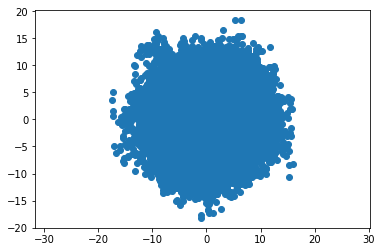

In [4]:
# Plot final shape of bacterial focus
plt.scatter(bactpos[0:maxlive][:,0], bactpos[0:maxlive][:,1])
plt.axis('equal')
plt.show

<function matplotlib.pyplot.show>

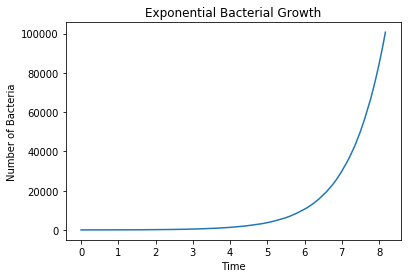

In [5]:
# Plot exponential bacterial growth
maxTime = step*0.01
time = np.arange(0, maxTime, 0.01)
plt.plot(time[0:step],bacteria_number[0:step])
plt.xlabel('Time')
plt.ylabel('Number of Bacteria')
plt.title('Exponential Bacterial Growth')
plt.show

In [9]:
# Use this to profile the simulation line by line

%lprun -f startSimulation startSimulation(nlive,D,krep,maxnbact)